# Starbucks Capstone Challenge: Predicting Offer Success


## 1. Assignment

This notebook contains my approach to the Capstone Project for the Udacity Data Scientist Nanodegree. As the data set and some instructions are given out, they can be found in this section.

### (a) Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### (b) Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### (c) Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### (d) Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

## 2. Problem Statement

Based on the introduction given in the assignment, my goal in this project is to build a machine learning model predicting  offer success based on the demographic information and the offer details that are provided in the data.

## 3. Data Exploration

In this section, I load and clean the data and perform some basic exploratory analyses to better understand how to successfully build a prediction model.

In [1]:
# package imports
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import json
import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, roc_auc_score
%matplotlib inline

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

As a first step, all three need to be read in.

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### (a) Portfolio data - offer information

First, let's take a quick look at the different offers in the portfolio. The schema and explanation of each variable according to the assignment details are as follows:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [3]:
portfolio.head(2)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


In [4]:
print("There are {} unique offers in the portfolio.".format(portfolio['id'].nunique()))
offer_type_counts = portfolio.groupby('offer_type')['id'].count()
print("These are distributed among the offer types as follows:\n BOGO:\t\t{}\n Discount:\t{}\n Informational:\t{}".format(offer_type_counts.loc['bogo'], offer_type_counts.loc['discount'], offer_type_counts.loc['informational']))

There are 10 unique offers in the portfolio.
These are distributed among the offer types as follows:
 BOGO:		4
 Discount:	4
 Informational:	2


In [5]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

Unsurprisingly, there are no missing values in the offer data.

The different channels as well as the offer types need to be represented differently for analysis. Here is a function that can be used to clean the portfolio data set:

In [6]:
# Clean portfolio data set
def clean_portfolio(portfolio=portfolio):
    '''
    cleans the portfolio dataframe for further analysis
    
    INPUT:
    portfolio - the dataframe to be cleaned (default: portfolio)
    
    OUTPUT:
    portfolio - the cleaned portfolio dataframe
    
    '''
    # clean channels
    channels = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)
    portfolio = pd.concat([portfolio, channels], axis=1)
    
    # clean offer types
    offer_types = pd.get_dummies(portfolio.offer_type)
    portfolio = pd.concat([portfolio, offer_types], axis=1)
    
    portfolio['offer'] = (portfolio['offer_type'] + "_" + portfolio['reward'].astype('str')
                          + "_for_" + portfolio['difficulty'].astype('str') + "_in_"
                          + portfolio['duration'].astype('str') + "days")
    
    # drop and rename columns
    portfolio.drop(['channels'], axis=1, inplace=True)
    portfolio.rename(columns={'id':'offer_id'},inplace=True)
    
    return portfolio

In [7]:
portfolio = clean_portfolio()
portfolio

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web,bogo,discount,informational,offer
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0,bogo_10_for_10_in_7days
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0,bogo_10_for_10_in_5days
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1,informational_0_for_0_in_4days
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0,bogo_5_for_5_in_7days
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0,discount_5_for_20_in_10days
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0,discount_3_for_7_in_7days
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0,discount_2_for_10_in_10days
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1,informational_0_for_0_in_3days
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0,bogo_5_for_5_in_5days
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0,discount_2_for_10_in_7days


### (c) Profile data - customer information

Next, let's take a look at the demographic customer data. The schema and explanation of each variable according to the assignment details are as follows:

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [8]:
profile.head(2)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0


Again, here is a function to clean the profile data for further analysis:

In [9]:
def clean_profile(profile=profile):
    '''
    cleans the profile dataframe for further analysis
    
    INPUT:
    profile - the dataframe to be cleaned (default: profile)
    
    OUTPUT:
    profile - the cleaned profile dataframe
    
    ''' 
    # recode missing values for age
    profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # drop entries with missing profile information
    #profile.dropna(inplace=True)
    
    # calculate membership duration
    profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
    profile['membership_duration'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
    profile['membership_duration'] = profile['membership_duration'].dt.days
    
    # rename columns
    profile.rename(columns={'id':'person_id'},inplace=True)
    
    return profile

In [10]:
profile = clean_profile()
profile

,gender,age,person_id,became_member_on,income,membership_duration
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,1502
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,1349
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,987
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,1416
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,1329
...,...,...,...,...,...,...
16995,F,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0,1025
16996,M,61.0,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0,986
16997,M,49.0,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0,1519
16998,F,83.0,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0,1844


In [11]:
profile.isnull().sum()

gender                 2175
age                    2175
person_id                 0
became_member_on          0
income                 2175
membership_duration       0
dtype: int64

It seems as though there are 2,175 out of 17,000 customers in the data set without information on gender, age and income. As those are not too many, my strategy is to drop those for the machine learning model. Thus, I refrain from implementing an impuation strategy here.

Before proceeding to the actual event data, let's take a first look at the demographic information we have for our customers:

In [12]:
profile.describe()

,age,income,membership_duration
count,14825.000000,14825.000000,17000.000000
mean,54.393524,65404.991568,1490.449882
std,17.383705,21598.299410,411.223904
min,18.000000,30000.000000,973.000000
25%,42.000000,49000.000000,1181.000000
50%,55.000000,64000.000000,1331.000000
75%,66.000000,80000.000000,1764.000000
max,101.000000,120000.000000,2796.000000


In [13]:
def plot_demographics(df, variable):
    '''
    returns a basic histogram and density plot for demographic variables
    
    INPUT:
    df - the dataframe including the variable to be plotted
    variable - the variable to be plotted
    
    OUTPUT:
    plot - basic histogram and density plot
    
    ''' 
    plot = sns.displot(data=df, x=variable, kde=True, bins=25, aspect=1.5)
    plot.set(title='{} distribution'.format(variable))
    
    return plot

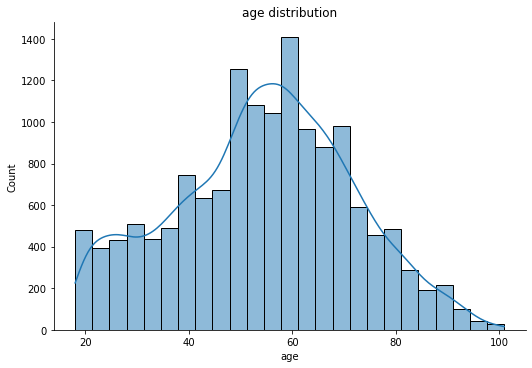

In [14]:
age_plot = plot_demographics(profile, 'age')

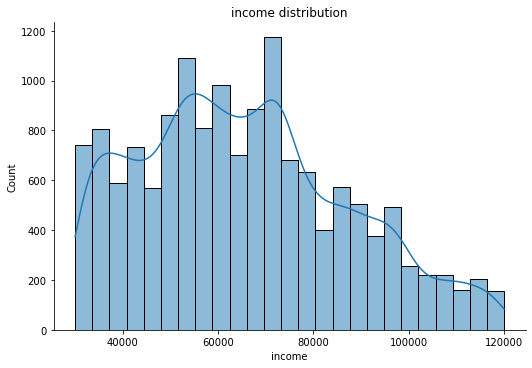

In [15]:
income_plot = plot_demographics(profile, 'income')

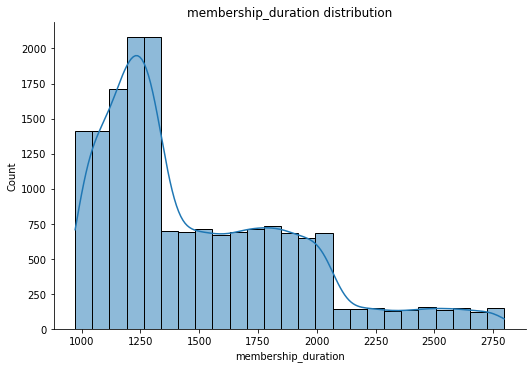

In [16]:
membership_duration_plot = plot_demographics(profile, 'membership_duration')

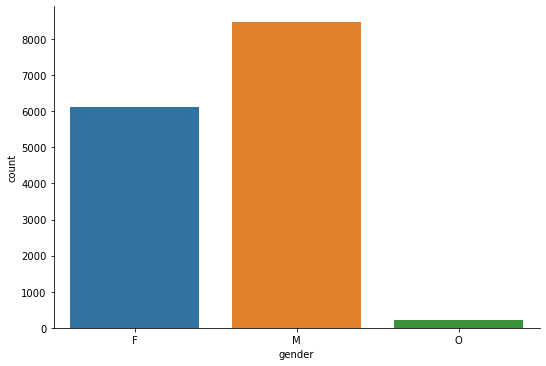

In [17]:
gender_plot = sns.catplot(data=profile, x='gender', kind='count', aspect=1.5)

### (c) Transcript data - events

Finally, let's take a look at the actual offer and transaction events. The schema and explanation of each variable according to the assignment details are as follows:

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [18]:
transcript.head(2)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [19]:
def clean_transcript(transcript=transcript):
    '''
    cleans the transcript dataframe for further analysis
    
    INPUT:
    transcript - the dataframe to be cleaned (default: transcript)
    
    OUTPUT:
    transcript - the cleaned transcript dataframe
    
    ''' 
    # unpack information in 'value' column to separate columns
    values = transcript['value'].apply(pd.Series)
    values.offer_id.fillna(values['offer id'], inplace=True)
    transcript = pd.concat([transcript, values], axis=1)
    
    # calculate number of offers received per person
    num_offers = transcript[transcript['event']=='offer received'].groupby('person').count().reset_index()
    num_offers.rename(columns={'offer_id':'num_offers'},inplace=True)
    transcript = pd.merge(transcript, num_offers[['person', 'num_offers']], how='left', on='person')
    
    # drop and rename columns
    transcript.drop(['offer id', 'value', 'reward'], axis=1, inplace=True)
    transcript.rename(columns={'person':'person_id'},inplace=True)
    
    return transcript

In [20]:
transcript = clean_transcript()
transcript

,person_id,event,time,amount,offer_id,num_offers
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,4.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,5.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,NaN,3.0
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,NaN,5.0
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,NaN,5.0
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,NaN,3.0


To better understand how the event data look like and which factors need to be addressed during the analysis, let's first take a look at one customer:

In [21]:
transcript[transcript['person_id']=='78afa995795e4d85b5d9ceeca43f5fef']

,person_id,event,time,amount,offer_id,num_offers
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,19.89,NaN,4.0
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,17.78,NaN,4.0
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,4.0
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,NaN,5a8bc65990b245e5a138643cd4eb9837,4.0
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,19.67,NaN,4.0
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,29.72,NaN,4.0
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,23.93,NaN,4.0


Looking at this subset of the transcript data for one customer, the following details become clear:

* A customer receives different offers over the course of the experiment; some overlap (see rows 150598 and 201572: the customer receives a second offer with the first one still valid)
* It can happen that an offer is completed without a customer having viewed the offer (see rows 218395 and 262138: the customer has already completed the offer before viewing it)

Those things need to be factored in when defining my outcome variable, 'offer success'.

In [22]:
combined = pd.merge(transcript, portfolio, how='left', on='offer_id')
combined.groupby(['offer_type', 'event']).person_id.count()

offer_type     event          
bogo           offer completed    15669
               offer received     30499
               offer viewed       25449
discount       offer completed    17910
               offer received     30543
               offer viewed       21445
informational  offer received     15235
               offer viewed       10831
Name: person_id, dtype: int64

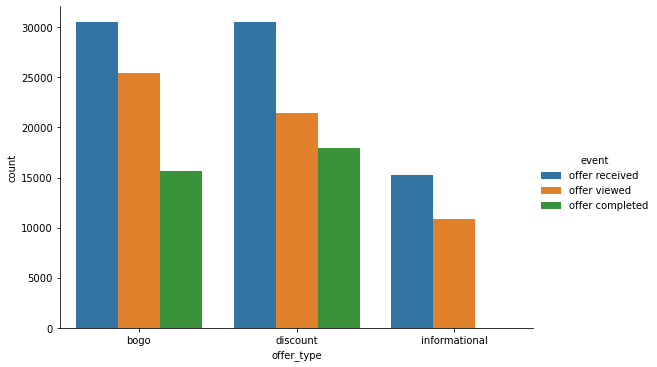

In [23]:
events_by_offer_type = sns.catplot(data=combined[combined['event']!='transaction'], x='offer_type',
                                   kind='count', hue='event', aspect=1.5)

As can be seen in the graph, there are roughly 30,000 BOGO and discount offers sent. Not all of them are viewed by customers, and again a smaller subset of those is completed.

What also becomes evident from the graph is that the informational offers need to be treated differently from the BOGO and dicsount offers, as there is no immediate measure for offer completion present in the data.

## 3. Predicting Offer Success

Having done some basic data exploration and cleaning to get a better understanding of the data, my next goal is to build a simple machine learning model to predict offer success based on the offer and customer characteristics.

### (a) Data Preparation

To prepare the event data for analysis based on the thoughts above, it is necessary to define which outcomes in the data can be classified as success cases. As BOGO and discount offers have 'offer completed' events while informational offers have not, I prepare data for the offer types separately, starting out with BOGO and discount offers.

#### BOGO and Discount Offers

In general, possible event paths for BOGO and discount offers are:

1. **successful offer**: offer received &rarr; offer viewed &rarr; transaction(s) &rarr; offer completed
2. **ineffective offer**: offer received &rarr; offer viewed
3. **unviewed offer**: offer received
4. **unviewed success**: offer received &rarr; transaction(s) &rarr; offer completed

While **successful offer** is the path that reflects that an offer was successfully completed after viewing it (i.e., the desirable outcome), both  **ineffective offer** and **unviewed offer** reflect that the offer was not successful, i.e., did not lead to transactions by the customer (or to insufficient transactions). However, it is important to keep in mind that  there can also be **unviewed success** cases, meaning that the customer has not viewed the offer, but completed it anyways, i.e., that the customer made transactions regardless of the offer.

Thus, it would be interesting to see how different customer groups show these behaviors in response to the offers: ideally, Starbucks might want to target those customer groups that exhibit event path 1, while not targeting those that are most likely to follow paths 2 and 3 (because those are not going to make transactions) or 4 (because those make transactions anyways, so Starbucks would actually lose money by giving them discounts or BOGO offers).

Based on these thoughts, I have to transform the data sets to include my outcome variables:

In [24]:
def prepare_offer_data_completion(df):
    '''
    cleans dataframe for further analysis based on offer completion
    
    INPUT:
    df - the dataframe to be cleaned
    
    OUTPUT:
    combined - the cleaned dataframe
    
    ''' 
    pd.options.mode.chained_assignment = None
    
    # identify success cases in 'offer completed' rows
    offers_completed = df[['person_id', 'event', 'time', 'offer_id', 'num_offers']].sort_values(['person_id','time'])
    offers_completed = offers_completed[(offers_completed['event']=='offer viewed') | (offers_completed['event']=='offer completed')]
    offers_completed['pre_offer_id'] = offers_completed.groupby(['person_id', 'offer_id'])['offer_id'].shift()
    offers_completed['success'] = np.where((offers_completed['event'] == 'offer completed')
                                           & (offers_completed['pre_offer_id'] == offers_completed['offer_id']),
                                           1, 0)
    offers_completed['unviewed_success'] = np.where((offers_completed['event'] == 'offer completed')
                                                    & (offers_completed['pre_offer_id'].isna()),
                                                    1, 0)
    offers_completed.drop(['pre_offer_id'], axis=1, inplace=True)
    
    # re-include 'offer received' rows
    received_offers = df[['person_id', 'event', 'time', 'offer_id', 'num_offers']][df['event']=='offer received'].sort_values(['person_id','time'])
    
    together = received_offers.append(offers_completed).sort_values(['person_id','time'])
    together = together.sort_values(['person_id','time'])
    
    # transmit information from 'offer completed' to corresponding 'offer received' rows
    successes = together[(together['event']=='offer received') | (together['event']=='offer completed')]
    successes['success'] = successes.groupby(['person_id', 'offer_id'])['success'].bfill()
    successes['unviewed_success'] = successes.groupby(['person_id', 'offer_id'])['unviewed_success'].bfill()
    result = successes[successes['event']=='offer received']
    
    # classify remaining offers as failures and fill missings
    result['failure'] = np.where((result['success'].isna()) & (result['unviewed_success'].isna()), 1, 0)
    result['success'] = np.where(result['success'].isna(), 0, result['success'])
    result['success'] = result['success'].astype('int')
    result['unviewed_success'] = np.where(result['unviewed_success'].isna(), 0, result['unviewed_success'])
    result['unviewed_success'] = result['unviewed_success'].astype('int')
    
    # build categorical outcome column
    result['outcome'] = np.where(result['success'] == 1, 'success',
                                 np.where(result['unviewed_success'] == 1, 'unviewed success', 'failure'))

    outcome_map = {'failure': 0, 'unviewed success': 1, 'success': 2}
    result['outcome_factor'] = result['outcome'].map(outcome_map)
    
    # add customer and offer information
    combined = pd.merge(result, portfolio, how='left', on='offer_id')
    combined = pd.merge(combined, profile, how='left', on='person_id')
    combined.drop(['event', 'became_member_on'], axis=1, inplace=True)
    
    pd.options.mode.chained_assignment = "warn"
    
    return combined
    

To prepare the event data for analysis based on the thoughts above, I create separate data sets for the different types of offers and clean them:

In [25]:
bogo = combined[combined['offer_type']=='bogo']
discount = combined[combined['offer_type']=='discount']

In [26]:
bogo_cleaned = prepare_offer_data_completion(bogo)
discount_cleaned = prepare_offer_data_completion(discount)
bogo_discount = bogo_cleaned.append(discount_cleaned)
bogo_discount.head(10)

,person_id,time,offer_id,num_offers,success,unviewed_success,failure,outcome,outcome_factor,reward,...,social,web,bogo,discount,informational,offer,gender,age,income,membership_duration
0,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,5.0,0,1,0,unviewed success,1,5,...,1,1,1,0,0,bogo_5_for_5_in_5days,M,33.0,72000.0,1434
1,00116118485d4dfda04fdbaba9a87b5c,168,f19421c1d4aa40978ebb69ca19b0e20d,2.0,0,0,1,failure,0,5,...,1,1,1,0,0,bogo_5_for_5_in_5days,None,NaN,NaN,1065
2,00116118485d4dfda04fdbaba9a87b5c,576,f19421c1d4aa40978ebb69ca19b0e20d,2.0,0,0,1,failure,0,5,...,1,1,1,0,0,bogo_5_for_5_in_5days,None,NaN,NaN,1065
3,0011e0d4e6b944f998e987f904e8c1e5,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,1,0,0,success,2,5,...,0,1,1,0,0,bogo_5_for_5_in_7days,O,40.0,57000.0,1171
4,0020c2b971eb4e9188eac86d93036a77,168,ae264e3637204a6fb9bb56bc8210ddfd,5.0,0,0,1,failure,0,10,...,1,0,1,0,0,bogo_10_for_10_in_7days,F,59.0,90000.0,1847
5,0020c2b971eb4e9188eac86d93036a77,408,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,1,0,0,success,2,10,...,1,1,1,0,0,bogo_10_for_10_in_5days,F,59.0,90000.0,1847
6,0020ccbbb6d84e358d3414a3ff76cffd,336,f19421c1d4aa40978ebb69ca19b0e20d,4.0,1,0,0,success,2,5,...,1,1,1,0,0,bogo_5_for_5_in_5days,F,24.0,60000.0,1595
7,0020ccbbb6d84e358d3414a3ff76cffd,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,4.0,1,0,0,success,2,5,...,0,1,1,0,0,bogo_5_for_5_in_7days,F,24.0,60000.0,1595
8,004b041fbfe44859945daa2c7f79ee64,504,f19421c1d4aa40978ebb69ca19b0e20d,3.0,1,0,0,success,2,5,...,1,1,1,0,0,bogo_5_for_5_in_5days,F,55.0,74000.0,1052
9,004c5799adbf42868b9cff0396190900,336,ae264e3637204a6fb9bb56bc8210ddfd,5.0,0,1,0,unviewed success,1,10,...,1,0,1,0,0,bogo_10_for_10_in_7days,M,54.0,99000.0,1820


Using the function, I have now arrived at a cleaned data set for BOGO and discount offers with one row per offer made that includes offer an customer information as well as outcome indicators that are going to be useful for building the model.

#### Informational Offers

For informational offers, there is no 'offer completed' event that I can use to define offer success. Thus, I use transaction data for defining which offers are successful.

In [27]:
def prepare_offer_data_transactions(df):
    '''
    cleans dataframe for further analysis based on transactions within validity period
    
    INPUT:
    df - the dataframe to be cleaned
    
    OUTPUT:
    test - the cleaned dataframe
    
    ''' 
    test = df.sort_values(['person_id','time'])

    # calculate remaining time for offers
    test['duration_hrs'] = test.duration * 24
    test['end_time'] = np.where(test['event']=='offer received', test['time'] + test['duration_hrs'], np.nan)
    test['end_time'] = test.groupby('person_id')['end_time'].ffill()
    test['remaining'] = test['end_time'] - test.time

    # fill in offer column for transactions if offer is still active
    test['offer'] = np.where((test['event']=='transaction') & (test['remaining']>=0), test['offer'].ffill(), test.offer)

    # get rid of all transactions that do not belong to an offer
    test = test[-test['offer'].isna()]

    # calculate transaction sum during offer validity period using transactions and offer viewed
    test_rest = test[(test['event']=='offer viewed')|(test['event']=='transaction')]
    uff = pd.DataFrame(test_rest.groupby(['person_id', 'offer'])['amount'].sum())
    uff.rename(columns={'amount':'sum'},inplace=True)
    test_rest_sum = pd.merge(test_rest, uff, how='left', on=['person_id', 'offer'])
    test_rest_sum['amount'] = np.where(test_rest_sum['event']=='offer viewed', test_rest_sum['sum'], test_rest_sum['amount'])
    test = test[test['event']=='offer received'].append(test_rest_sum).sort_values(['person_id','time'])
    test = test.drop(columns=['duration_hrs', 'end_time', 'remaining', 'sum'])

    # transfer transaction sum to 'offer received' rows
    test = test[-(test['event']=='transaction')]
    test['amount'] = test.groupby(['person_id', 'offer'])['amount'].shift(-1)
    test = test[test['event']=='offer received']
    test['amount'] = test['amount'].fillna(0)
    
    # add success indicator
    test['success'] = np.where(test['amount']>0,1,0)
    test[['unviewed_success', 'failure', 'outcome', 'outcome_factor']] =-99
    
    # add customer information
    test = pd.merge(test, profile, how='left', on='person_id')
    test.drop(['event', 'became_member_on'], axis=1, inplace=True)

    return test

To prepare the event data for analysis based on the thoughts above, I create a separate data set for informational offers (this time including transactions) and clean them:

In [28]:
info = combined[(combined['offer_type']=='informational') |(combined['event']=='transaction')]

In [29]:
info_cleaned = prepare_offer_data_transactions(info)
info_cleaned.head(10)

,person_id,time,amount,offer_id,num_offers,reward,difficulty,duration,offer_type,email,...,offer,success,unviewed_success,failure,outcome,outcome_factor,gender,age,income,membership_duration
0,0009655768c64bdeb2e877511632db8f,168,22.16,5a8bc65990b245e5a138643cd4eb9837,5.0,0.0,0.0,3.0,informational,1.0,...,informational_0_for_0_in_3days,1,-99,-99,-99,-99,M,33.0,72000.0,1434
1,0009655768c64bdeb2e877511632db8f,336,8.57,3f207df678b143eea3cee63160fa8bed,5.0,0.0,0.0,4.0,informational,1.0,...,informational_0_for_0_in_4days,1,-99,-99,-99,-99,M,33.0,72000.0,1434
2,0011e0d4e6b944f998e987f904e8c1e5,0,0.00,3f207df678b143eea3cee63160fa8bed,5.0,0.0,0.0,4.0,informational,1.0,...,informational_0_for_0_in_4days,0,-99,-99,-99,-99,O,40.0,57000.0,1171
3,0011e0d4e6b944f998e987f904e8c1e5,336,0.00,5a8bc65990b245e5a138643cd4eb9837,5.0,0.0,0.0,3.0,informational,1.0,...,informational_0_for_0_in_3days,0,-99,-99,-99,-99,O,40.0,57000.0,1171
4,0020c2b971eb4e9188eac86d93036a77,504,51.10,5a8bc65990b245e5a138643cd4eb9837,5.0,0.0,0.0,3.0,informational,1.0,...,informational_0_for_0_in_3days,1,-99,-99,-99,-99,F,59.0,90000.0,1847
5,0020ccbbb6d84e358d3414a3ff76cffd,408,58.87,5a8bc65990b245e5a138643cd4eb9837,4.0,0.0,0.0,3.0,informational,1.0,...,informational_0_for_0_in_3days,1,-99,-99,-99,-99,F,24.0,60000.0,1595
6,003d66b6608740288d6cc97a6903f4f0,0,2.51,5a8bc65990b245e5a138643cd4eb9837,5.0,0.0,0.0,3.0,informational,1.0,...,informational_0_for_0_in_3days,1,-99,-99,-99,-99,F,26.0,73000.0,1373
7,003d66b6608740288d6cc97a6903f4f0,336,12.27,3f207df678b143eea3cee63160fa8bed,5.0,0.0,0.0,4.0,informational,1.0,...,informational_0_for_0_in_4days,1,-99,-99,-99,-99,F,26.0,73000.0,1373
8,00426fe3ffde4c6b9cb9ad6d077a13ea,0,25.92,5a8bc65990b245e5a138643cd4eb9837,5.0,0.0,0.0,3.0,informational,1.0,...,informational_0_for_0_in_3days,1,-99,-99,-99,-99,F,19.0,65000.0,1689
9,004b041fbfe44859945daa2c7f79ee64,168,0.00,3f207df678b143eea3cee63160fa8bed,3.0,0.0,0.0,4.0,informational,1.0,...,informational_0_for_0_in_4days,0,-99,-99,-99,-99,F,55.0,74000.0,1052


#### Combined Data

Now that data for all offer types have been cleaned and enriched by a binary measure for offer success, the data can be put together into one data set. This data set will then be used to build my classification model.

In [30]:
info_test = info_cleaned.drop(columns=['amount'])
all_offers = bogo_discount.append(info_test)
all_offers.shape

(76277, 25)

### (b) Model Estimation

Now that the data sets are prepared, my goal is to build a model that predicts offer outcome based on the demographic and offer information available in the data. Ideally, this model can be used to further refine offers and target them at new customers in the future.

#### Basic Model

To this end, I build a simple classification model using a Random Forest Classification algorithm. The model function below also reports basic evaluation metrics for the model built:

In [31]:
def build_classification_model(df, target, target_names,
                               model=RandomForestClassifier(max_depth=20, random_state=42)):
    '''
    builds classification model
    
    INPUT:
    df - the dataframe to be analyzed
    target - the outcome variable
    target_names - labels for the target values
    model - the model (default: random forest classification with max tree depth of 20, random state of 42)
    
    OUTPUT:
    model - the classification model
    
    '''
    df = df.dropna(how='any', axis=0)
    
    gender = pd.get_dummies(df.gender)
    df = pd.concat([df, gender], axis=1)
    
    X = df.drop(columns=['person_id', 'offer_id', 'time', 'offer_type', 'gender', 'offer',
                         'success', 'unviewed_success', 'failure', 'outcome', 'outcome_factor'])
    y = df.pop(target)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
    
    model = model

    model.fit(X_train, y_train)
    
    conf_matrix = plot_confusion_matrix(model, X_test, y_test, display_labels=target_names,
                                        cmap=plt.cm.Blues, normalize=None)
    conf_matrix.ax_.set_title('Confusion matrix')
    
    model_predictions = model.predict(X_test)
    print(classification_report(y_test, model_predictions, target_names=target_names))
    
    print("Overall model accuracy:\t {}".format(accuracy_score(y_test, model_predictions)))
    
    train_probs = model.predict_proba(X_train)
    model_probs = model.predict_proba(X_test)
    print("Train ROC AUC score:\t {}".format(roc_auc_score(y_train, train_probs[:, 1])))
    print("Test ROC AUC score:\t {}".format(roc_auc_score(y_test, model_probs[:, 1])))
    
    return model

Let's put the model to action and see how it fares in predicting offer success:

              precision    recall  f1-score   support

     failure       0.72      0.71      0.71     10390
     success       0.69      0.70      0.69      9561

    accuracy                           0.70     19951
   macro avg       0.70      0.70      0.70     19951
weighted avg       0.70      0.70      0.70     19951

Overall model accuracy:	 0.7031727732945717
Train ROC AUC score:	 0.996143780340031
Test ROC AUC score:	 0.7678192325475275


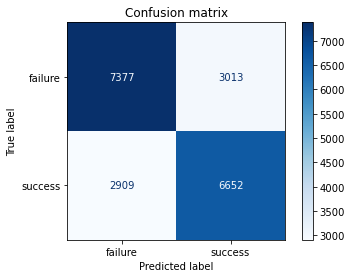

In [32]:
overall_model = build_classification_model(all_offers, 'success', ['failure', 'success'])

The model does not perform that well. Thus, I try to improve model performance in the next section before taking a closer look at the most important features for predicting offer success.

#### Improving Model Performance

To improve performance of the Random Forest Classifier model, I use randomized search to find better model parameters.

First, let's see which parameters are currently being used:

In [33]:
overall_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [34]:
params = {'n_estimators': [50, 100, 250, 500, 1000],
           'max_features': ['auto', 'log2'],
           'max_depth': [5, 10, 20, 50, None],
           'min_samples_split': [2, 5, 10],
           'min_samples_leaf': [1, 4, 10],
           'criterion' : ['gini', 'entropy'],
           'bootstrap': [True, False]}

cv = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=42),
                        param_distributions = params,
                        n_iter = 50, cv = 3, verbose = 1, random_state = 42,
                        scoring = 'roc_auc')

all_offers_prep = all_offers.dropna(how='any', axis=0)    
gender = pd.get_dummies(all_offers_prep.gender)
all_offers_prep = pd.concat([all_offers_prep, gender], axis=1)

X = all_offers_prep.drop(columns=['person_id', 'offer_id', 'time', 'offer_type', 'gender', 'offer',
                                     'success', 'unviewed_success', 'failure', 'outcome', 'outcome_factor'])
y = all_offers_prep.pop('success')
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

score = cv.fit(X_train, y_train)

score.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 50,
 'criterion': 'gini',
 'bootstrap': True}

              precision    recall  f1-score   support

     failure       0.71      0.73      0.72     10390
     success       0.70      0.67      0.68      9561

    accuracy                           0.70     19951
   macro avg       0.70      0.70      0.70     19951
weighted avg       0.70      0.70      0.70     19951

Overall model accuracy:	 0.7027216680868127
Train ROC AUC score:	 0.937432356037147
Test ROC AUC score:	 0.7670439009776543


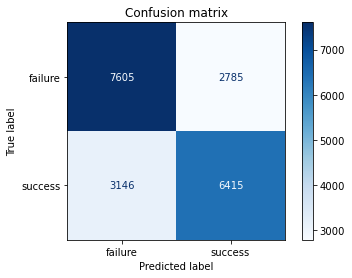

In [35]:
opt_model = RandomForestClassifier(n_estimators=1000, min_samples_split=2, min_samples_leaf=4,
                                         max_features='auto', max_depth=50, criterion='gini',
                                         bootstrap=True, random_state=42)
model_opt = build_classification_model(all_offers, 'success', ['failure', 'success'], model=opt_model)

The optimal model found via random search does not perform better than the initial model using mostly default settings.

### (c) Descriptive analysis of most important features

Now, I am interested in how exactly the most influential features according to the classification model influence offer success. I determine these with the help of another function:

In [36]:
def most_important_features(df, model):
    
    df = df.dropna(how='any', axis=0)
    
    gender = pd.get_dummies(df.gender)
    df = pd.concat([df, gender], axis=1)
    
    X = df.drop(columns=['person_id', 'offer_id', 'time', 'offer_type', 'gender', 'offer',
                         'success', 'unviewed_success', 'failure', 'outcome', 'outcome_factor'])
    
    feat_imp = pd.DataFrame(model.feature_importances_, index=X.columns,
                            columns=['importance']).sort_values('importance', ascending=False).reset_index()
    feat_imp.rename(columns={'index':'feature'},inplace=True)
    
    plot = sns.catplot(data=feat_imp.reset_index(), y='feature', x='importance', kind='bar', aspect=2)
    plot.set(title='Feature importance')
    
    return feat_imp

,feature,importance
0,membership_duration,0.336016
1,income,0.237495
2,age,0.225214
3,num_offers,0.062296
4,social,0.043319
5,duration,0.017715
6,difficulty,0.017397
7,reward,0.016533
8,M,0.008653
9,mobile,0.007874


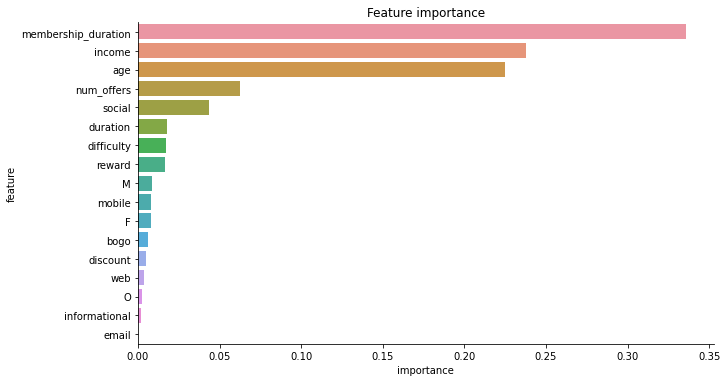

In [37]:
most_important_features(all_offers, overall_model)

Let's take a closer look at membership duration, income, age, the total number of offers received by the customers and the channel 'social' as those are the five most important factors in my model.

#### Membership duration

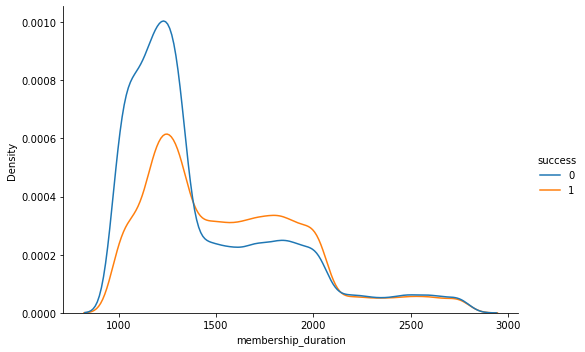

In [38]:
outcome_by_duration = sns.displot(data=all_offers, x='membership_duration',
                                  kind='kde', hue='success', aspect=1.5)

In [39]:
all_offers.groupby('success')['membership_duration'].mean()

success
0    1431.515351
1    1562.298702
Name: membership_duration, dtype: float64

Offers are more likely to be successful for members that have been in the program longer. This effect disappears for members with a very high tenure.

#### Income

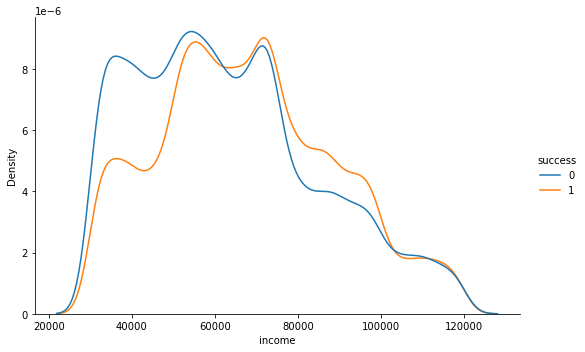

In [40]:
success_by_income = sns.displot(data=all_offers, x='income', kind='kde', hue='success', aspect=1.5)

In [41]:
all_offers.groupby('success')['income'].mean()

success
0    63151.442168
1    67759.699117
Name: income, dtype: float64

Offers are more likely to be successful for members with higher incomes.

##### Age

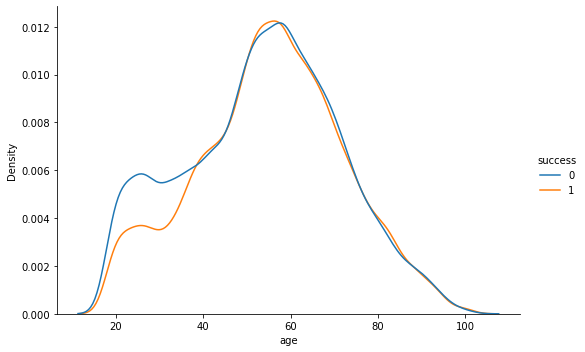

In [42]:
success_by_age = sns.displot(data=all_offers, x='age', kind='kde', hue='success', aspect=1.5)

In [43]:
all_offers.groupby('success')['age'].mean()

success
0    53.439470
1    55.369362
Name: age, dtype: float64

The age effect is mainly driven by younger customers, for which offers are less likely to be successful. This difference disappears at around age 40.

#### Total number of received offers

In [44]:
all_offers.groupby(['num_offers'])['success'].mean()

num_offers
1.0    0.479452
2.0    0.453279
3.0    0.437993
4.0    0.439455
5.0    0.452605
6.0    0.450929
Name: success, dtype: float64

Offers tend to be more successful if the total number of received offers is either very low or very high (U-shaped relationship)

#### Social

In [45]:
all_offers.groupby(['social'])['success'].mean()

social
0.0    0.320782
1.0    0.532299
Name: success, dtype: float64

Offers are more likely to be successful when they are sent out via the channel 'social'.

#### Which offers are most successful?

In [46]:
pd.DataFrame(all_offers.groupby(['offer'])['success'].mean()).reset_index().sort_values('success', ascending=False)

,offer,success
4,discount_2_for_10_in_10days,0.649204
8,informational_0_for_0_in_3days,0.626936
6,discount_3_for_7_in_7days,0.617578
2,bogo_5_for_5_in_5days,0.515388
0,bogo_10_for_10_in_5days,0.400369
9,informational_0_for_0_in_4days,0.391887
1,bogo_10_for_10_in_7days,0.384565
3,bogo_5_for_5_in_7days,0.340888
5,discount_2_for_10_in_7days,0.333988
7,discount_5_for_20_in_10days,0.216875


## 4. Discussion

### (a) Results

In this project, my goal was to predict offer success based on the available offer and customer information. To this end, I have built a simple classification model using a random forest classifier.

The random forest classification model can be used to predict whether an offer is going to be successfully completed based on customer and offer characteristics. The final model has an accuracy of 71%, which is a decent number for business purposes, although there is certainly room for improvement (for ideas how to approach this, see below).

The most relevant factors for offer success based on the model are:

1. Membership duration
2. Income
3. Age
4. Total number of received offers
5. Usage of the 'social' channel


### (b) Conclusion: Reflection and Improvement

The main caveats in this project from my point of view were to properly define and construct the outcome variables as those had to be carefully constructed depending on possible event paths and offer types.

Possible improvements of the project include:

* Use alternative modeling techniques to see whether model performance can be improved in this way (e.g., a decision tree classifier instead of the random forest classifier).
* Do not drop the observations with missing values, but use some kind of imputation strategy to see whether the model can be improved this way.
* Explore the impact of offers on revenue by constructing an additional outcome value based on transactions made. This would make it possible to provide additional useful information to Starbucks.